In [1]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [2]:
import numpy as np
import fenics as fe
from fenics import grad, dot, dx, ds
import matplotlib.pyplot as plt

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv004
--------------------------------------------------------------------------


In [3]:
# physical parameters
W = 0.1 # m
H = 0.1 # m
rho = 1000 # kg/m^2

# shear modulus and bulk modulus
G = 1e3 # Pa
K = 1e5 # Pa

# Lame's parameters
mu = G
lam = K - 2/3 * G
assert lam > 0, lam

g = 9.81 # m/s^2

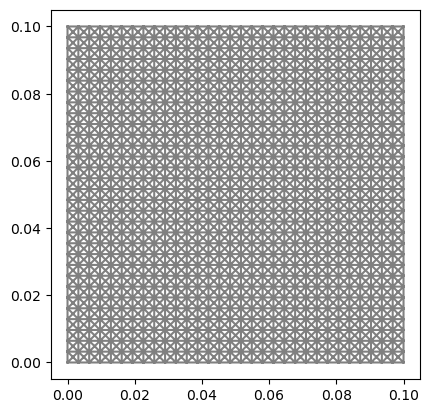

In [4]:
# define mesh and function space
n_nodes_x = 32
n_nodes_y = 32
n_elems_x = n_nodes_x - 1
n_elems_y = n_nodes_y - 1
mesh = fe.RectangleMesh(
    fe.Point(0, 0), fe.Point(W, H), n_elems_x, n_elems_y, diagonal='crossed'
)
V = fe.VectorFunctionSpace(mesh, 'CG', 1)
fe.plot(mesh)

In [5]:
# define initial and boundary condition
ic_expression = fe.Constant((0,0))
u_n2 = fe.interpolate(ic_expression, V)
u_n1 = fe.interpolate(ic_expression, V)

def clamped_boundary(x, on_boundary):
    return on_boundary and fe.near(x[1], H)

bc_expression = fe.Constant((0,0))
bc = fe.DirichletBC(V, bc_expression, clamped_boundary)

In [6]:
# define strain and stress
def epsilon(u):
    return (fe.grad(u) + fe.grad(u).T) / 2

def sigma(u):
    I = fe.Identity(u.geometric_dimension())
    return lam * fe.div(u) * I + 2 * mu * epsilon(u)

PDE problem

\begin{align*}
    \nabla \cdot \sigma + \mathbf{f} &= \rho \mathbf{u}''
\end{align*}

Time discretization

\begin{align*}
    \nabla \cdot \sigma^n + \mathbf{f}^n &= \rho \left( \frac{\mathbf{u}^n - 2\mathbf{u}^{n-1} + \mathbf{u}^{n-2}}{\Delta t^2} \right) \\
    \nabla \cdot \sigma^n + \mathbf{f}^n &= k \left( \mathbf{u}^n - 2\mathbf{u}^{n-1} + \mathbf{u}^{n-2} \right) \\
    \nabla \cdot \sigma^n  - k \mathbf{u}^n &= k \left( -2\mathbf{u}^{n-1} + \mathbf{u}^{n-2} \right) - \mathbf{f}^n \\
    -\nabla \cdot \sigma^n  + k \mathbf{u}^n &= k \left( 2\mathbf{u}^{n-1} - \mathbf{u}^{n-2} \right) + \mathbf{f}^n \\
\end{align*}

Variational formulation

\begin{align*}
    \int \left[ -\nabla \cdot \sigma^n  + k \mathbf{u}^n \right] \cdot\mathbf{v} \, dx &= \int \left[ k \left( 2\mathbf{u}^{n-1} - \mathbf{u}^{n-2} \right) + \mathbf{f}^n \right] \cdot \mathbf{v} \, dx \\
    \int -(\nabla \cdot \sigma^n) \cdot \mathbf{v} + k \mathbf{u}^n \cdot \mathbf{v} \, dx &= \int k \left( 2\mathbf{u}^{n-1} - \mathbf{u}^{n-2} \right) \cdot \mathbf{v} + \mathbf{f}^n \cdot \mathbf{v} \, dx \\
    \int \sigma^n : \nabla \mathbf{v} + k \mathbf{u}^n \cdot \mathbf{v} \, dx &= \int k \left( 2\mathbf{u}^{n-1} - \mathbf{u}^{n-2} \right) \cdot \mathbf{v} + \mathbf{f}^n \cdot \mathbf{v} \, dx + \oint \mathbf{T} \cdot \mathbf{v} \, ds \\
    \int \sigma(\mathbf{u}^n) : \epsilon(\mathbf{v}) + k \mathbf{u}^n \cdot \mathbf{v} \, dx &= \int k \left( 2\mathbf{u}^{n-1} - \mathbf{u}^{n-2} \right) \cdot \mathbf{v} + \mathbf{f}^n \cdot \mathbf{v} \, dx + \oint \mathbf{T} \cdot \mathbf{v} \, ds
\end{align*}


In [29]:
# time-stepping parameters
T = 5
n_steps = 10
dt = T / n_steps
dt

0.5

In [30]:
from fenics import inner, dot, grad, dx, ds

class BoundaryTraction(fe.UserExpression):

    def __init__(self, a, omega, t=0):
        super().__init__()
        self.a = a
        self.omega = omega
        self.t = t

    def value_shape(self):
        return (2,)

    def eval(self, values, x):
        if fe.near(x[1], 0):
            values[1] = self.a * np.sin(np.pi * self.omega * self.t)**2
        else:
            values[...] = 0

# define variational problem
u = fe.TrialFunction(V)
v = fe.TestFunction(V)

# body forces due to gravity
f = fe.Constant((0, -rho * g * 0))

# traction at the boundary
T = BoundaryTraction(a=1000, omega=0.2)

#a = inner(sigma(u), epsilon(v)) * dx
#L = dot(f, v) * dx + dot(T, v) * ds

k = rho / dt**2

a = inner(sigma(u), epsilon(v)) * dx + k * dot(u, v) * dx
L = dot(f, v) * dx + dot(T, v) * ds + k * dot(2*u_n1 - u_n2, v) * dx 

In [31]:
%%time
import os, tqdm

u_n2.interpolate(ic_expression)
u_n1.interpolate(ic_expression)
u = fe.Function(V)

video_name = '../videos/boxsim4'
os.makedirs(video_name, exist_ok=True)

A = fe.assemble(a)

t = 0
for i in tqdm.tqdm(range(n_steps)):
    t += dt
    b = fe.assemble(L)
    T.t = t
    bc.apply(A, b)
    fe.solve(A, u.vector(), b)
    u_n2.assign(u_n1)
    u_n1.assign(u)

    if True: # plot solution
        frame_file = os.path.join(video_name, f'frame{i:04d}.png')
        fig, ax = plt.subplots()
        fe.plot(u, cmap='magma', mode='displacement')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_xlim(-0.02, 0.12)
        ax.set_ylim(-0.02, 0.12)
        fig.savefig(frame_file)
        plt.close(fig)
    

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

CPU times: user 4.96 s, sys: 349 ms, total: 5.31 s
Wall time: 3.16 s


5.0

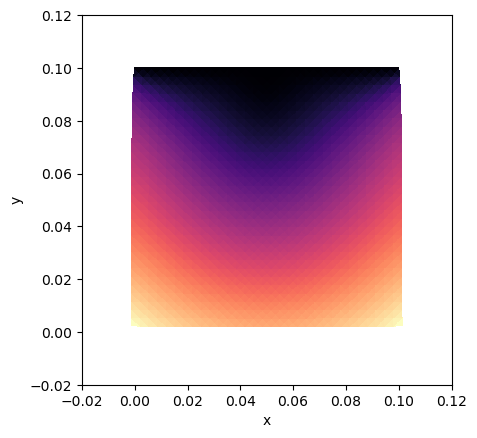

In [22]:
fe.plot(u, cmap='magma', mode='displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.02, 0.12)
plt.ylim(-0.02, 0.12)
t